Using device: cuda
seed: 2027

Starting training...
Epoch 1/50 [0.03s] - Train Loss: 0.279579, Val Loss: 0.168173
Epoch 2/50 [0.03s] - Train Loss: 0.154922, Val Loss: 0.113379
Epoch 3/50 [0.03s] - Train Loss: 0.175265, Val Loss: 0.087459
Epoch 4/50 [0.03s] - Train Loss: 0.131962, Val Loss: 0.081770
Epoch 5/50 [0.03s] - Train Loss: 0.086549, Val Loss: 0.091384
Epoch 6/50 [0.03s] - Train Loss: 0.109144, Val Loss: 0.088198
Epoch 7/50 [0.03s] - Train Loss: 0.114518, Val Loss: 0.095087
Epoch 8/50 [0.03s] - Train Loss: 0.104223, Val Loss: 0.085295
Epoch 9/50 [0.03s] - Train Loss: 0.116532, Val Loss: 0.086188
Epoch 10/50 [0.03s] - Train Loss: 0.097471, Val Loss: 0.092482
Epoch 11/50 [0.03s] - Train Loss: 0.090447, Val Loss: 0.095013
Epoch 12/50 [0.03s] - Train Loss: 0.090168, Val Loss: 0.089058
Epoch 13/50 [0.03s] - Train Loss: 0.101652, Val Loss: 0.087212
Epoch 14/50 [0.03s] - Train Loss: 0.098665, Val Loss: 0.100188
Epoch 15/50 [0.03s] - Train Loss: 0.087646, Val Loss: 0.091111
Epoch 16/50 

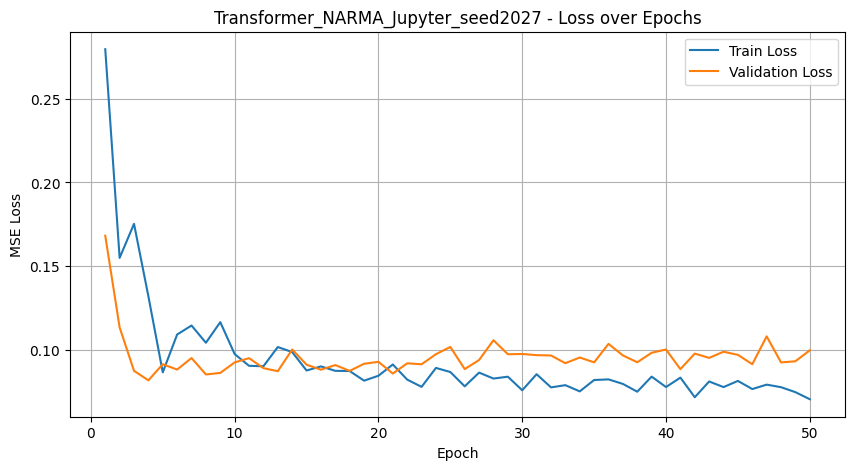


Generating final predictions on the full dataset...
Prediction plot saved to Transformer_NARMA_Jupyter_seed2027/prediction_vs_truth.png


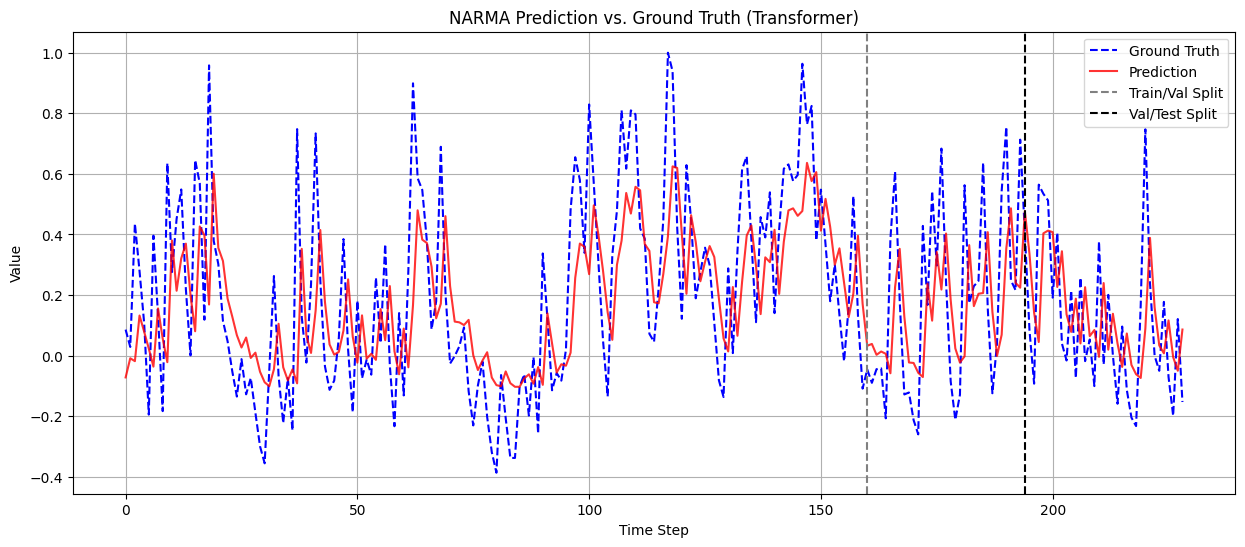

Predictions saved to Transformer_NARMA_Jupyter_seed2027/prediction_vs_truth.csv


In [5]:
import torch
import torch.nn as nn
import numpy as np
import os
import math
import time
from datetime import datetime
from pandas import DataFrame
import matplotlib.pyplot as plt

# Make sure narma.py is in the same directory or accessible
from narma import get_narma_data

# ===================================================================
# 1. Hyperparameters and Configuration
# ===================================================================
SEED = 2027
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001
D_MODEL = 32   # Embedding dimension
N_HEAD = 4     # Number of attention heads
D_HID = 64     # Dimension of feedforward network
N_LAYERS = 2   # Number of Transformer Encoder layers
exp_name = f"Transformer_NARMA_Jupyter_seed{SEED}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===================================================================
# 2. Model Definition
# ===================================================================
class PositionalEncoding(nn.Module):
    """Injects positional information into the input sequence."""
    def __init__(self, d_model, dropout=0.1, max_len=500):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    """A vanilla Transformer Encoder model for sequence prediction."""
    def __init__(self, input_size, d_model, nhead, d_hid, nlayers, output_size, dropout=0.2):
        super(TransformerModel, self).__init__()
        self.encoder = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, d_hid, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, output_size)

    def forward(self, src):
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output[:, -1, :])
        return output

# ===================================================================
# 3. Helper Functions
# ===================================================================
def train_epoch(model, optimizer, loader, loss_fn, device):
    model.train(); total_loss = 0
    for X_batch, Y_batch in loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = loss_fn(output.squeeze(), Y_batch.squeeze())
        loss.backward(); optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def test_epoch(model, loader, loss_fn, device):
    model.eval(); total_loss = 0
    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            output = model(X_batch)
            loss = loss_fn(output.squeeze(), Y_batch.squeeze())
            total_loss += loss.item()
    return total_loss / len(loader)

def save_and_plot_metrics(exp_name, metrics_data):
    """Saves metrics to CSV and plots the loss curves."""
    if not os.path.exists(exp_name): os.makedirs(exp_name)
    df_metrics = DataFrame(metrics_data)
    csv_path = os.path.join(exp_name, "final_training_metrics.csv")
    df_metrics.to_csv(csv_path, index=False)
    print(f"Final metrics saved to {csv_path}")
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(df_metrics['epoch'], df_metrics['train_loss'], label='Train Loss')
    plt.plot(df_metrics['epoch'], df_metrics['val_loss'], label='Validation Loss')
    plt.title(f'{exp_name} - Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plot_path = os.path.join(exp_name, "loss_plot.png")
    plt.savefig(plot_path)
    print(f"Plot saved to {plot_path}")
    plt.show()

# ===================================================================
# 4. Prediction Plotting and Saving Function
# ===================================================================
def generate_and_save_predictions(model, full_data_x, full_data_y, train_end_idx, val_end_idx, exp_name):
    """Generates predictions, plots them against truth, and saves both."""
    print("\nGenerating final predictions on the full dataset...")
    model.eval()
    with torch.no_grad():
        full_data_x = full_data_x.to(device)
        predictions = model(full_data_x).cpu().numpy().squeeze()
    
    ground_truth = full_data_y.cpu().numpy().squeeze()
    
    # --- Plotting ---
    plt.figure(figsize=(15, 6))
    plt.plot(ground_truth, label='Ground Truth', color='blue', linestyle='--')
    plt.plot(predictions, label='Prediction', color='red', alpha=0.8)
    
    plt.axvline(x=train_end_idx, color='gray', linestyle='--', label='Train/Val Split')
    plt.axvline(x=val_end_idx, color='black', linestyle='--', label='Val/Test Split')
    
    plt.title('NARMA Prediction vs. Ground Truth (Transformer)')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    
    plot_path = os.path.join(exp_name, "prediction_vs_truth.png")
    plt.savefig(plot_path)
    print(f"Prediction plot saved to {plot_path}")
    plt.show()
    
    # --- Saving to CSV ---
    df_preds = DataFrame({
        'ground_truth': ground_truth,
        'prediction': predictions
    })
    csv_path = os.path.join(exp_name, "prediction_vs_truth.csv")
    df_preds.to_csv(csv_path, index=False)
    print(f"Predictions saved to {csv_path}")


# ===================================================================
# 5. Main Execution Block
# ===================================================================
torch.manual_seed(SEED); np.random.seed(SEED)
print(f"Using device: {device}")

# --- Data Loading ---
x, y = get_narma_data(n_samples=240, seq_length=10, seed=SEED)
if x.dim() == 2: x = x.unsqueeze(-1)
train_end_idx, val_end_idx = int(0.70 * len(x)), int(0.85 * len(x))
x_train, y_train = x[:train_end_idx], y[:train_end_idx]
x_val, y_val = x[train_end_idx:val_end_idx], y[train_end_idx:val_end_idx]
x_test, y_test = x[val_end_idx:], y[val_end_idx:]
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_val, y_val), batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=BATCH_SIZE)

# --- Model Initialization ---
model = TransformerModel(input_size=1, d_model=D_MODEL, nhead=N_HEAD, d_hid=D_HID, nlayers=N_LAYERS, output_size=1).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- Training Loop ---
metrics = {'epoch': [], 'train_loss': [], 'val_loss': [], 'test_loss': []}
print("\nStarting training...")
for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss = train_epoch(model, optimizer, train_loader, loss_fn, device)
    val_loss = test_epoch(model, val_loader, loss_fn, device)
    test_loss = test_epoch(model, test_loader, loss_fn, device) if epoch == EPOCHS - 1 else np.nan
    metrics['epoch'].append(epoch + 1); metrics['train_loss'].append(train_loss)
    metrics['val_loss'].append(val_loss); metrics['test_loss'].append(test_loss)
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{EPOCHS} [{epoch_time:.2f}s] - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

print(f"\nTraining Complete. Final Test Loss: {metrics['test_loss'][-1]:.6f}")

# --- Final Analysis ---
save_and_plot_metrics(exp_name, metrics)
generate_and_save_predictions(model, x, y, train_end_idx, val_end_idx, exp_name)


### Hyperparameter tuning

STAGE 1: Starting Grid Search using Seed: 2025
Using device: cuda
Getting NARMA data for tuning...
seed: 2025

[1/16] Testing params: {'d_model': 16, 'nhead': 2, 'nlayers': 1, 'learning_rate': 0.001}
Number of trainable parameters: 2,273
Validation Loss for params {'d_model': 16, 'nhead': 2, 'nlayers': 1, 'learning_rate': 0.001}: 0.049010

[2/16] Testing params: {'d_model': 16, 'nhead': 2, 'nlayers': 1, 'learning_rate': 0.0005}
Number of trainable parameters: 2,273
Validation Loss for params {'d_model': 16, 'nhead': 2, 'nlayers': 1, 'learning_rate': 0.0005}: 0.047513

[3/16] Testing params: {'d_model': 16, 'nhead': 2, 'nlayers': 2, 'learning_rate': 0.001}
Number of trainable parameters: 4,497
Validation Loss for params {'d_model': 16, 'nhead': 2, 'nlayers': 2, 'learning_rate': 0.001}: 0.043437

[4/16] Testing params: {'d_model': 16, 'nhead': 2, 'nlayers': 2, 'learning_rate': 0.0005}
Number of trainable parameters: 4,497
Validation Loss for params {'d_model': 16, 'nhead': 2, 'nlayers': 

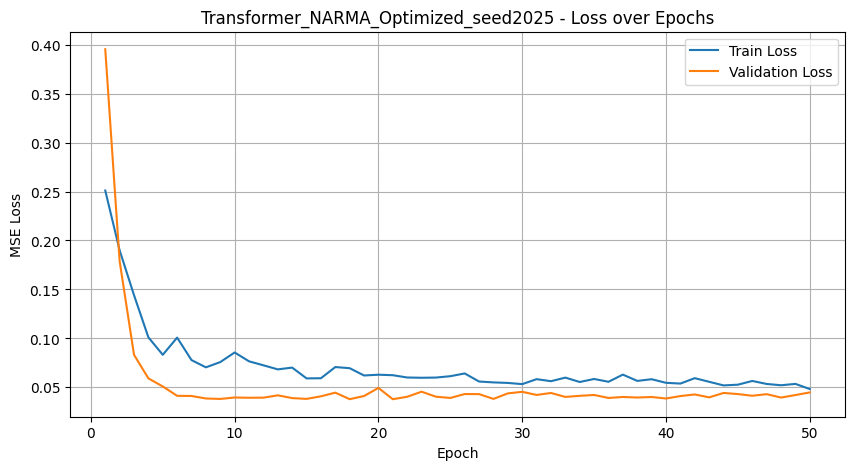


Generating final predictions on the full dataset...
Prediction plot saved to Transformer_NARMA_Optimized_seed2025/prediction_vs_truth.png


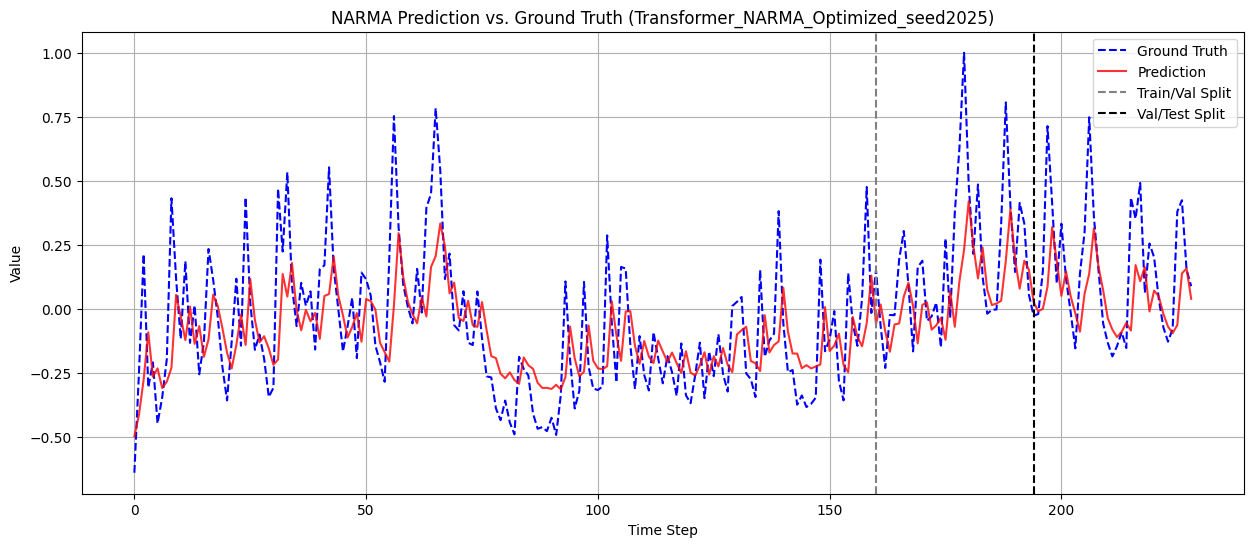

Predictions saved to Transformer_NARMA_Optimized_seed2025/prediction_vs_truth.csv

--- Running Final Experiment for Seed: 2026 ---
Getting NARMA data for seed 2026...
seed: 2026
Final model parameters for seed 2026: 8,641
Epoch 10/50 - Train Loss: 0.081669, Val Loss: 0.080894
Epoch 20/50 - Train Loss: 0.077521, Val Loss: 0.055094
Epoch 30/50 - Train Loss: 0.078023, Val Loss: 0.061460
Epoch 40/50 - Train Loss: 0.065138, Val Loss: 0.059124
Epoch 50/50 - Train Loss: 0.060266, Val Loss: 0.056632

--- Final Training Complete for Seed 2026 ---
Final Test Loss for Seed 2026: 0.029496
Final metrics saved to Transformer_NARMA_Optimized_seed2026/final_training_metrics.csv
Plot saved to Transformer_NARMA_Optimized_seed2026/loss_plot.png


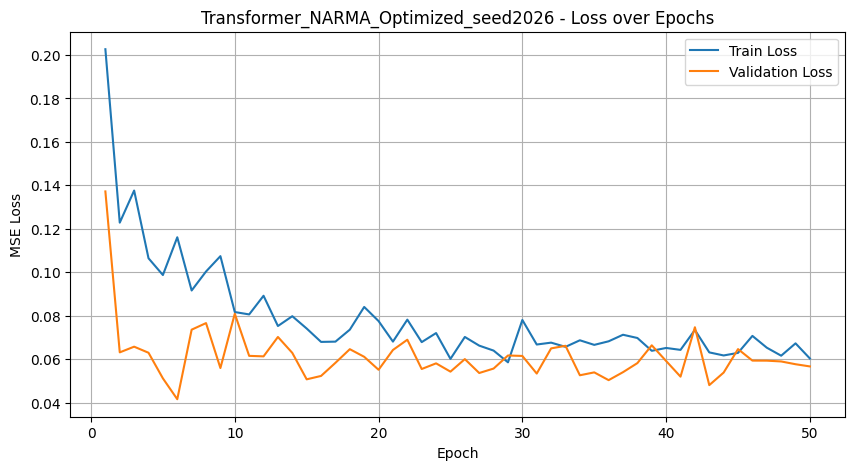


Generating final predictions on the full dataset...
Prediction plot saved to Transformer_NARMA_Optimized_seed2026/prediction_vs_truth.png


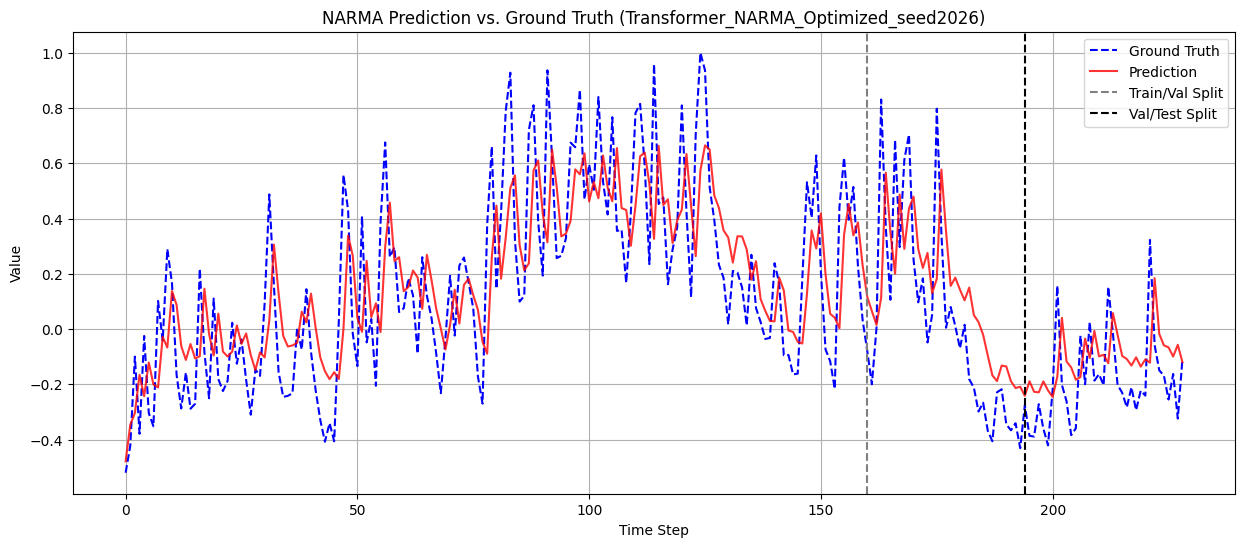

Predictions saved to Transformer_NARMA_Optimized_seed2026/prediction_vs_truth.csv

--- Running Final Experiment for Seed: 2027 ---
Getting NARMA data for seed 2027...
seed: 2027
Final model parameters for seed 2027: 8,641
Epoch 10/50 - Train Loss: 0.109067, Val Loss: 0.092402
Epoch 20/50 - Train Loss: 0.093219, Val Loss: 0.096794
Epoch 30/50 - Train Loss: 0.085687, Val Loss: 0.105609
Epoch 40/50 - Train Loss: 0.075033, Val Loss: 0.104079
Epoch 50/50 - Train Loss: 0.076430, Val Loss: 0.102023

--- Final Training Complete for Seed 2027 ---
Final Test Loss for Seed 2027: 0.054855
Final metrics saved to Transformer_NARMA_Optimized_seed2027/final_training_metrics.csv
Plot saved to Transformer_NARMA_Optimized_seed2027/loss_plot.png


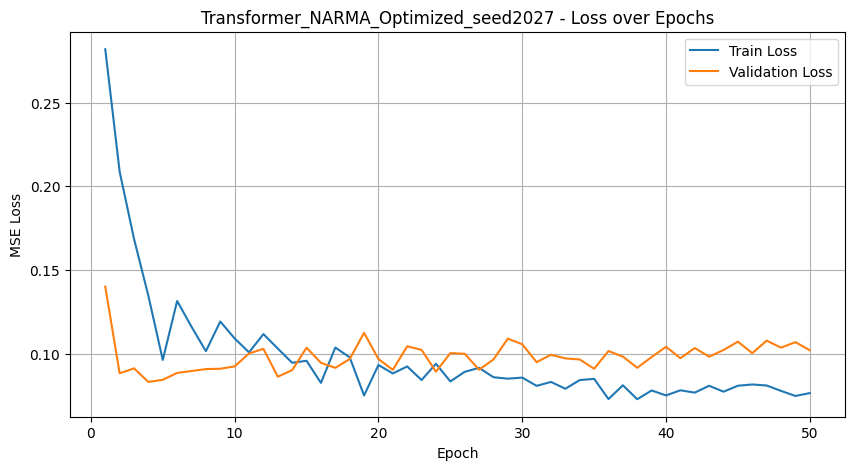


Generating final predictions on the full dataset...
Prediction plot saved to Transformer_NARMA_Optimized_seed2027/prediction_vs_truth.png


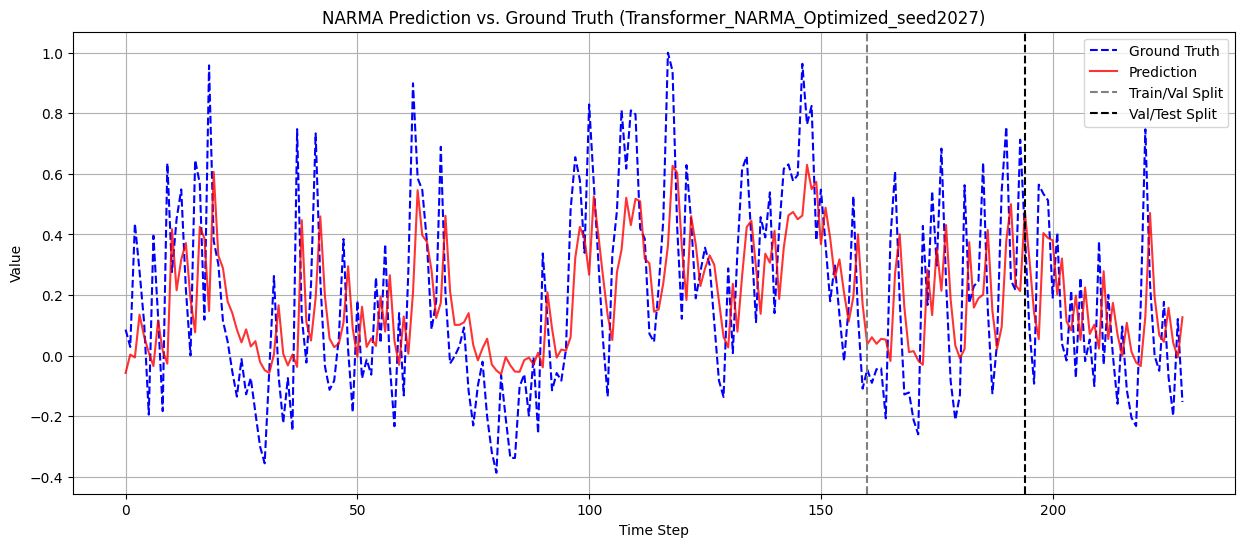

Predictions saved to Transformer_NARMA_Optimized_seed2027/prediction_vs_truth.csv

Grid search results saved to Transformer_NARMA_Optimized_seed2025/grid_search_results.csv


In [10]:
import torch
import torch.nn as nn
import numpy as np
import os
import math
import time
from datetime import datetime
from pandas import DataFrame
import matplotlib.pyplot as plt
import itertools

# Make sure narma.py is in the same directory or accessible
from narma import get_narma_data

# ===================================================================
# 1. Configuration and Hyperparameter Grid
# ===================================================================
# --- Seed Configuration ---
TUNING_SEED = 2025
EVALUATION_SEEDS = [2025, 2026, 2027]

# --- Training Configuration ---
GRID_SEARCH_EPOCHS = 50  # Epochs for each grid search run
FINAL_EPOCHS = 50 # Epochs for the final model after finding best params
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Grid Search Hyperparameters for Transformer ---
# Note: d_model must be divisible by nhead
param_grid = {
    'd_model': [16, 32],
    'nhead': [2, 4],
    'nlayers': [1, 2],
    'learning_rate': [0.001, 0.0005]
}

# ===================================================================
# 2. Model Definition
# ===================================================================
class PositionalEncoding(nn.Module):
    """Injects positional information into the input sequence."""
    def __init__(self, d_model, dropout=0.1, max_len=500):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    """A vanilla Transformer Encoder model for sequence prediction."""
    def __init__(self, input_size, d_model, nhead, d_hid, nlayers, output_size, dropout=0.2):
        super(TransformerModel, self).__init__()
        self.encoder = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, d_hid, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, output_size)

    def forward(self, src):
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output[:, -1, :])
        return output

# ===================================================================
# 3. Helper Functions
# ===================================================================
def count_parameters(model):
    """Counts the number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_epoch(model, optimizer, loader, loss_fn, device):
    model.train(); total_loss = 0
    for X_batch, Y_batch in loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = loss_fn(output.squeeze(), Y_batch.squeeze())
        loss.backward(); optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def test_epoch(model, loader, loss_fn, device):
    model.eval(); total_loss = 0
    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            output = model(X_batch)
            loss = loss_fn(output.squeeze(), Y_batch.squeeze())
            total_loss += loss.item()
    return total_loss / len(loader)

def save_and_plot_metrics(exp_name, metrics_data):
    if not os.path.exists(exp_name): os.makedirs(exp_name)
    df_metrics = DataFrame(metrics_data)
    csv_path = os.path.join(exp_name, "final_training_metrics.csv")
    df_metrics.to_csv(csv_path, index=False)
    print(f"Final metrics saved to {csv_path}")
    
    plt.figure(figsize=(10, 5))
    plt.plot(df_metrics['epoch'], df_metrics['train_loss'], label='Train Loss')
    plt.plot(df_metrics['epoch'], df_metrics['val_loss'], label='Validation Loss')
    plt.title(f'{exp_name} - Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plot_path = os.path.join(exp_name, "loss_plot.png")
    plt.savefig(plot_path)
    print(f"Plot saved to {plot_path}")
    plt.show()

def generate_and_save_predictions(model, full_data_x, full_data_y, train_end_idx, val_end_idx, exp_name):
    print("\nGenerating final predictions on the full dataset...")
    model.eval()
    with torch.no_grad():
        full_data_x = full_data_x.to(device)
        predictions = model(full_data_x).cpu().numpy().squeeze()
    
    ground_truth = full_data_y.cpu().numpy().squeeze()
    
    plt.figure(figsize=(15, 6))
    plt.plot(ground_truth, label='Ground Truth', color='blue', linestyle='--')
    plt.plot(predictions, label='Prediction', color='red', alpha=0.8)
    plt.axvline(x=train_end_idx, color='gray', linestyle='--', label='Train/Val Split')
    plt.axvline(x=val_end_idx, color='black', linestyle='--', label='Val/Test Split')
    plt.title(f'NARMA Prediction vs. Ground Truth ({exp_name})')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    
    plot_path = os.path.join(exp_name, "prediction_vs_truth.png")
    plt.savefig(plot_path)
    print(f"Prediction plot saved to {plot_path}")
    plt.show()
    
    df_preds = DataFrame({'ground_truth': ground_truth, 'prediction': predictions})
    csv_path = os.path.join(exp_name, "prediction_vs_truth.csv")
    df_preds.to_csv(csv_path, index=False)
    print(f"Predictions saved to {csv_path}")

# ===================================================================
# 4. Main Execution Block
# ===================================================================
# --- STAGE 1: HYPERPARAMETER TUNING ON A SINGLE SEED ---
print("="*50)
print(f"STAGE 1: Starting Grid Search using Seed: {TUNING_SEED}")
print("="*50)

# --- Setup for Tuning ---
torch.manual_seed(TUNING_SEED)
np.random.seed(TUNING_SEED)
print(f"Using device: {device}")

# --- Data Loading for Tuning ---
print("Getting NARMA data for tuning...")
x, y = get_narma_data(n_samples=240, seq_length=10, seed=TUNING_SEED)
if x.dim() == 2: x = x.unsqueeze(-1)

train_end_idx = int(0.70 * len(x))
val_end_idx = int(0.85 * len(x))
x_train, y_train = x[:train_end_idx], y[:train_end_idx]
x_val, y_val = x[train_end_idx:val_end_idx], y[train_end_idx:val_end_idx]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_val, y_val), batch_size=BATCH_SIZE)

# --- Grid Search ---
best_val_loss = float('inf')
best_params = {}
grid_search_results = []

keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

for i, params in enumerate(param_combinations):
    if params['d_model'] % params['nhead'] != 0:
        print(f"\n[{i+1}/{len(param_combinations)}] Skipping invalid params: {params}")
        continue
        
    print(f"\n[{i+1}/{len(param_combinations)}] Testing params: {params}")
    
    model = TransformerModel(
        input_size=1, d_model=params['d_model'], nhead=params['nhead'], 
        d_hid=params['d_model'] * 2, nlayers=params['nlayers'], output_size=1
    ).to(device)
    
    print(f"Number of trainable parameters: {count_parameters(model):,}")
    
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])

    for epoch in range(GRID_SEARCH_EPOCHS):
        train_loss = train_epoch(model, optimizer, train_loader, loss_fn, device)
    
    val_loss = test_epoch(model, val_loader, loss_fn, device)
    print(f"Validation Loss for params {params}: {val_loss:.6f}")
    grid_search_results.append({'params': str(params), 'val_loss': val_loss})

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = params

print(f"\n--- Grid Search Complete ---")
print(f"Best Validation Loss: {best_val_loss:.6f}")
print(f"Best Hyperparameters Found: {best_params}")

# --- STAGE 2: FINAL EVALUATION ON MULTIPLE SEEDS ---
print("\n" + "="*50)
print(f"STAGE 2: Starting Final Evaluation for Seeds: {EVALUATION_SEEDS}")
print("="*50)

for seed in EVALUATION_SEEDS:
    print(f"\n--- Running Final Experiment for Seed: {seed} ---")
    exp_name = f"Transformer_NARMA_Optimized_seed{seed}"
    
    torch.manual_seed(seed)
    np.random.seed(seed)

    print(f"Getting NARMA data for seed {seed}...")
    x, y = get_narma_data(n_samples=240, seq_length=10, seed=seed)
    if x.dim() == 2: x = x.unsqueeze(-1)
    
    train_end_idx = int(0.70 * len(x))
    val_end_idx = int(0.85 * len(x))
    x_train, y_train = x[:train_end_idx], y[:train_end_idx]
    x_val, y_val = x[train_end_idx:val_end_idx], y[train_end_idx:val_end_idx]
    x_test, y_test = x[val_end_idx:], y[val_end_idx:]

    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_val, y_val), batch_size=BATCH_SIZE)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=BATCH_SIZE)
    
    final_model = TransformerModel(
        input_size=1, d_model=best_params['d_model'], nhead=best_params['nhead'],
        d_hid=best_params['d_model'] * 2, nlayers=best_params['nlayers'], output_size=1
    ).to(device)
    
    print(f"Final model parameters for seed {seed}: {count_parameters(final_model):,}")
    
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])

    metrics = {'epoch': [], 'train_loss': [], 'val_loss': [], 'test_loss': []}
    for epoch in range(FINAL_EPOCHS):
        start_time = time.time()
        train_loss = train_epoch(final_model, optimizer, train_loader, loss_fn, device)
        val_loss = test_epoch(final_model, val_loader, loss_fn, device)
        test_loss = test_epoch(final_model, test_loader, loss_fn, device) if epoch == FINAL_EPOCHS - 1 else np.nan
        
        metrics['epoch'].append(epoch + 1)
        metrics['train_loss'].append(train_loss)
        metrics['val_loss'].append(val_loss)
        metrics['test_loss'].append(test_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{FINAL_EPOCHS} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

    print(f"\n--- Final Training Complete for Seed {seed} ---")
    final_test_loss = metrics['test_loss'][-1]
    print(f"Final Test Loss for Seed {seed}: {final_test_loss:.6f}")

    save_and_plot_metrics(exp_name, metrics)
    generate_and_save_predictions(final_model, x, y, train_end_idx, val_end_idx, exp_name)

first_eval_folder = f"Transformer_NARMA_Optimized_seed{EVALUATION_SEEDS[0]}"
df_grid = DataFrame(grid_search_results)
grid_csv_path = os.path.join(first_eval_folder, "grid_search_results.csv")
df_grid.to_csv(grid_csv_path, index=False)
print(f"\nGrid search results saved to {grid_csv_path}")
